# ThinkBrake: Result Analysis

## Import and Configs

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from pathlib import Path
import seaborn as sns
from matplotlib.patches import Patch

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update(
    {
        "figure.figsize": (14, 7),
        "font.size": 11,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "figure.dpi": 100,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "font.family": "sans-serif",
    }
)

model_colors = sns.color_palette("dark", 8)
benchmark_colors = sns.color_palette("dark", 10)
method_palette = {
    "Baseline": "#2C3E50",
    "Thinkless": "#E74C3C",
    "ThinkBrake": "#3498DB",
}
threshold_palette = sns.color_palette("Blues", 6)[1:]
bar_colors = [
    "#2C3E50",
    "#3498DB",
    "#E67E22",
    "#27AE60",
    "#9B59B6",
    "#1ABC9C",
    "#E74C3C",
    "#95A5A6",
]

line_colors = [
    "#1A5276",
    "#B03A2E",
    "#1E8449",
    "#7D3C98",
    "#B9770E",
    "#117A65",
    "#6C3483",
    "#1F618D",
]

markers = ["o", "s", "^", "D", "v", "p", "h", "*"]

In [2]:
def calc_subplot_layout(n_items, max_cols=4):
    if n_items == 0:
        return 1, 1, (6, 4)

    cols = min(n_items, max_cols)
    rows = math.ceil(n_items / cols)
    fig_width = 5.5 * cols
    fig_height = 4.5 * rows
    return rows, cols, (fig_width, fig_height)


def create_dynamic_subplots(n_items, max_cols=4, sharey=False):
    rows, cols, figsize = calc_subplot_layout(n_items, max_cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, sharey=sharey)

    if n_items == 1:
        axes = np.array([axes])
    else:
        axes = np.array(axes).flatten()

    for i in range(n_items, len(axes)):
        axes[i].set_visible(False)

    return fig, axes


def add_value_labels(ax, bars, fmt=".1f", rotation=0, fontsize=9, offset=0.5):
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.annotate(
                f"{height:{fmt}}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, offset),
                textcoords="offset points",
                ha="center",
                va="bottom",
                fontsize=fontsize,
                rotation=rotation,
            )


def format_model_name(name, short_names):
    return short_names.get(name, name.split("/")[-1])


def load_detailed_results(model_dir, benchmark, method="rollout"):
    base_path = Path(f"../outputs/{model_dir}")
    math_benchmarks = ["gsm8k", "math500", "aime2024", "aime2025"]
    general_benchmarks = ["gpqa-diamond"]
    tool_benchmarks = ["bfcl-v1", "bfcl-v2"]

    if benchmark in math_benchmarks:
        category = "math"
    elif benchmark in general_benchmarks:
        category = "general"
    elif benchmark in tool_benchmarks:
        category = "tool"
    else:
        return None

    if method == "rollout":
        file_path = base_path / category / "rollout" / f"{benchmark}_result.jsonl"
    else:
        file_path = (
            base_path / category / "thinkbrake" / method / f"{benchmark}_result.jsonl"
        )

    if not file_path.exists():
        return None

    results = []
    with open(file_path, "r") as f:
        for line in f:
            if line.strip():
                results.append(json.loads(line))
    return results

## Load Dataset

In [3]:
INCLUDE_MODELS = [
    "Qwen_Qwen3-4B-Thinking-2507",
    "Qwen_Qwen3-4B",
    "Qwen_Qwen3-14B",
    "Qwen_Qwen3-32B",
    "deepseek-ai_DeepSeek-R1-Distill-Llama-8B",
    "deepseek-ai_DeepSeek-R1-Distill-Qwen-7B",
    "microsoft_phi-4-reasoning",
]

INCLUDE_BENCHMARKS = [
    # "gsm8k",
    # "math500",
    # "aime2024",
    # "aime2025",
    # "gpqa-diamond",
    # "mmlu-redux",
    "bfcl-v1",
    "bfcl-v2",
]

INCLUDE_THRESHOLDS = [
    # "0.0",
    "0.1",
    "0.25",
    "1.0",
    "2.5",
    # "5.0",
]

In [4]:
with open("../outputs/leaderboard_rollout.json", "r") as f:
    rollout_data = json.load(f)

with open("../outputs/leaderboard_thinkbrake.json", "r") as f:
    thinkbrake_data = json.load(f)

model_name_map = {
    "Qwen_Qwen3-4B-Thinking-2507": "Qwen/Qwen3-4B-Thinking-2507",
    "Qwen_Qwen3-4B": "Qwen/Qwen3-4B",
    "Qwen_Qwen3-14B": "Qwen/Qwen3-14B",
    "Qwen_Qwen3-32B": "Qwen/Qwen3-32B",
    "deepseek-ai_DeepSeek-R1-Distill-Llama-8B": "deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
    "deepseek-ai_DeepSeek-R1-Distill-Qwen-7B": "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
    "microsoft_phi-4-reasoning": "microsoft/phi-4-reasoning",
}

short_names = {
    "Qwen/Qwen3-4B-Thinking-2507": "Qwen3-4B-2507",
    "Qwen/Qwen3-4B": "Qwen3-4B",
    "Qwen/Qwen3-14B": "Qwen3-14B",
    "Qwen/Qwen3-32B": "Qwen3-32B",
    "deepseek-ai/DeepSeek-R1-Distill-Llama-8B": "DS-R1-8B",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B": "DS-R1-7B",
    "microsoft/phi-4-reasoning": "Phi-4-Reasoning",
}

benchmarks = INCLUDE_BENCHMARKS
thresholds = sorted(INCLUDE_THRESHOLDS, key=lambda x: float(x))

filtered_rollout_data = {k: v for k, v in rollout_data.items() if k in INCLUDE_MODELS}
filtered_thinkbrake_data = {
    k: v
    for k, v in thinkbrake_data.items()
    if k in [model_name_map.get(m, m) for m in INCLUDE_MODELS]
}
baseline_data = filtered_rollout_data

# Analysis


## Token Savings across Benchmarks

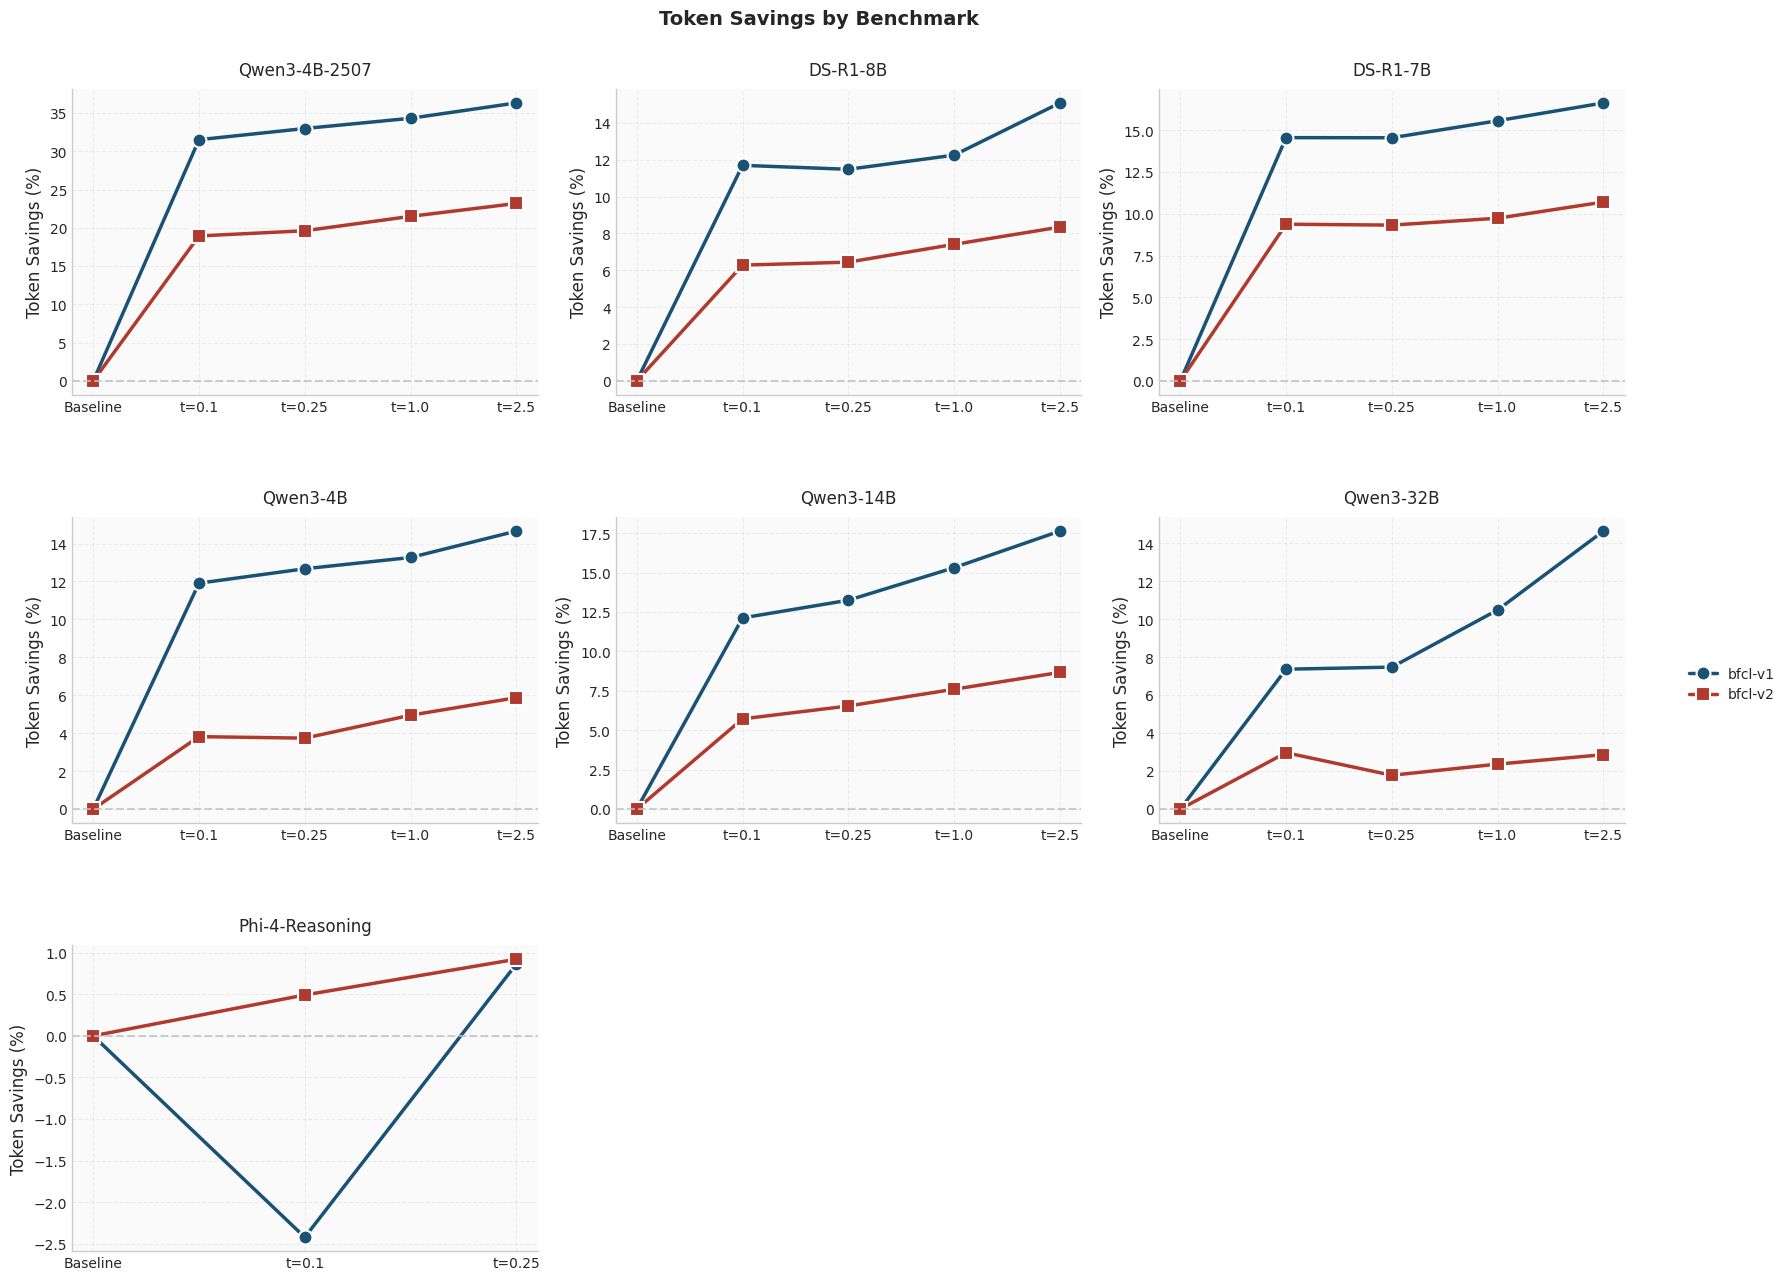

In [5]:
num_models = len(filtered_rollout_data)
if num_models == 0:
    print("No data available for this plot.")
else:
    fig, axes = create_dynamic_subplots(num_models, max_cols=3)

    for model_idx, (rollout_name, rollout_model_data) in enumerate(
        filtered_rollout_data.items()
    ):
        ax = axes[model_idx]
        mapped_name = model_name_map.get(rollout_name, rollout_name)
        display_name = short_names.get(mapped_name, rollout_name)

        for bench_idx, benchmark in enumerate(benchmarks):
            try:
                if benchmark not in rollout_model_data:
                    continue

                baseline_tokens = rollout_model_data[benchmark]["avg_token_length"]

                if (
                    mapped_name in filtered_thinkbrake_data
                    and benchmark in filtered_thinkbrake_data[mapped_name]
                ):
                    tb_data = filtered_thinkbrake_data[mapped_name][benchmark]
                    x_vals = ["Baseline"]
                    y_vals = [0]

                    for thresh in thresholds:
                        key = f"threshold_{thresh}"
                        if key in tb_data:
                            x_vals.append(f"t={thresh}")
                            token_savings = (
                                1 - tb_data[key]["avg_token_length"] / baseline_tokens
                            ) * 100
                            y_vals.append(token_savings)

                    color = line_colors[bench_idx % len(line_colors)]
                    ax.plot(
                        x_vals,
                        y_vals,
                        marker=markers[bench_idx % len(markers)],
                        linewidth=2.5,
                        markersize=10,
                        color=color,
                        label=benchmark,
                        markeredgecolor="white",
                        markeredgewidth=1.5,
                    )
            except Exception:
                continue

        ax.axhline(y=0, color="#BDC3C7", linestyle="--", alpha=0.8, linewidth=1.5)
        ax.set_ylabel("Token Savings (%)")
        ax.set_title(f"{display_name}", fontsize=12, pad=10)
        ax.grid(True, alpha=0.3, linestyle="--")
        ax.tick_params(axis="x", rotation=0)
        ax.set_facecolor("#FAFAFA")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        ncol=1,
        fontsize=10,
        framealpha=0.9,
    )
    plt.suptitle(
        "Token Savings by Benchmark",
        fontsize=14,
        fontweight="bold",
        y=1.00,
    )
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.08, hspace=0.4)
    plt.show()

## Per-Model Bar Chart: Accuracy by Benchmark

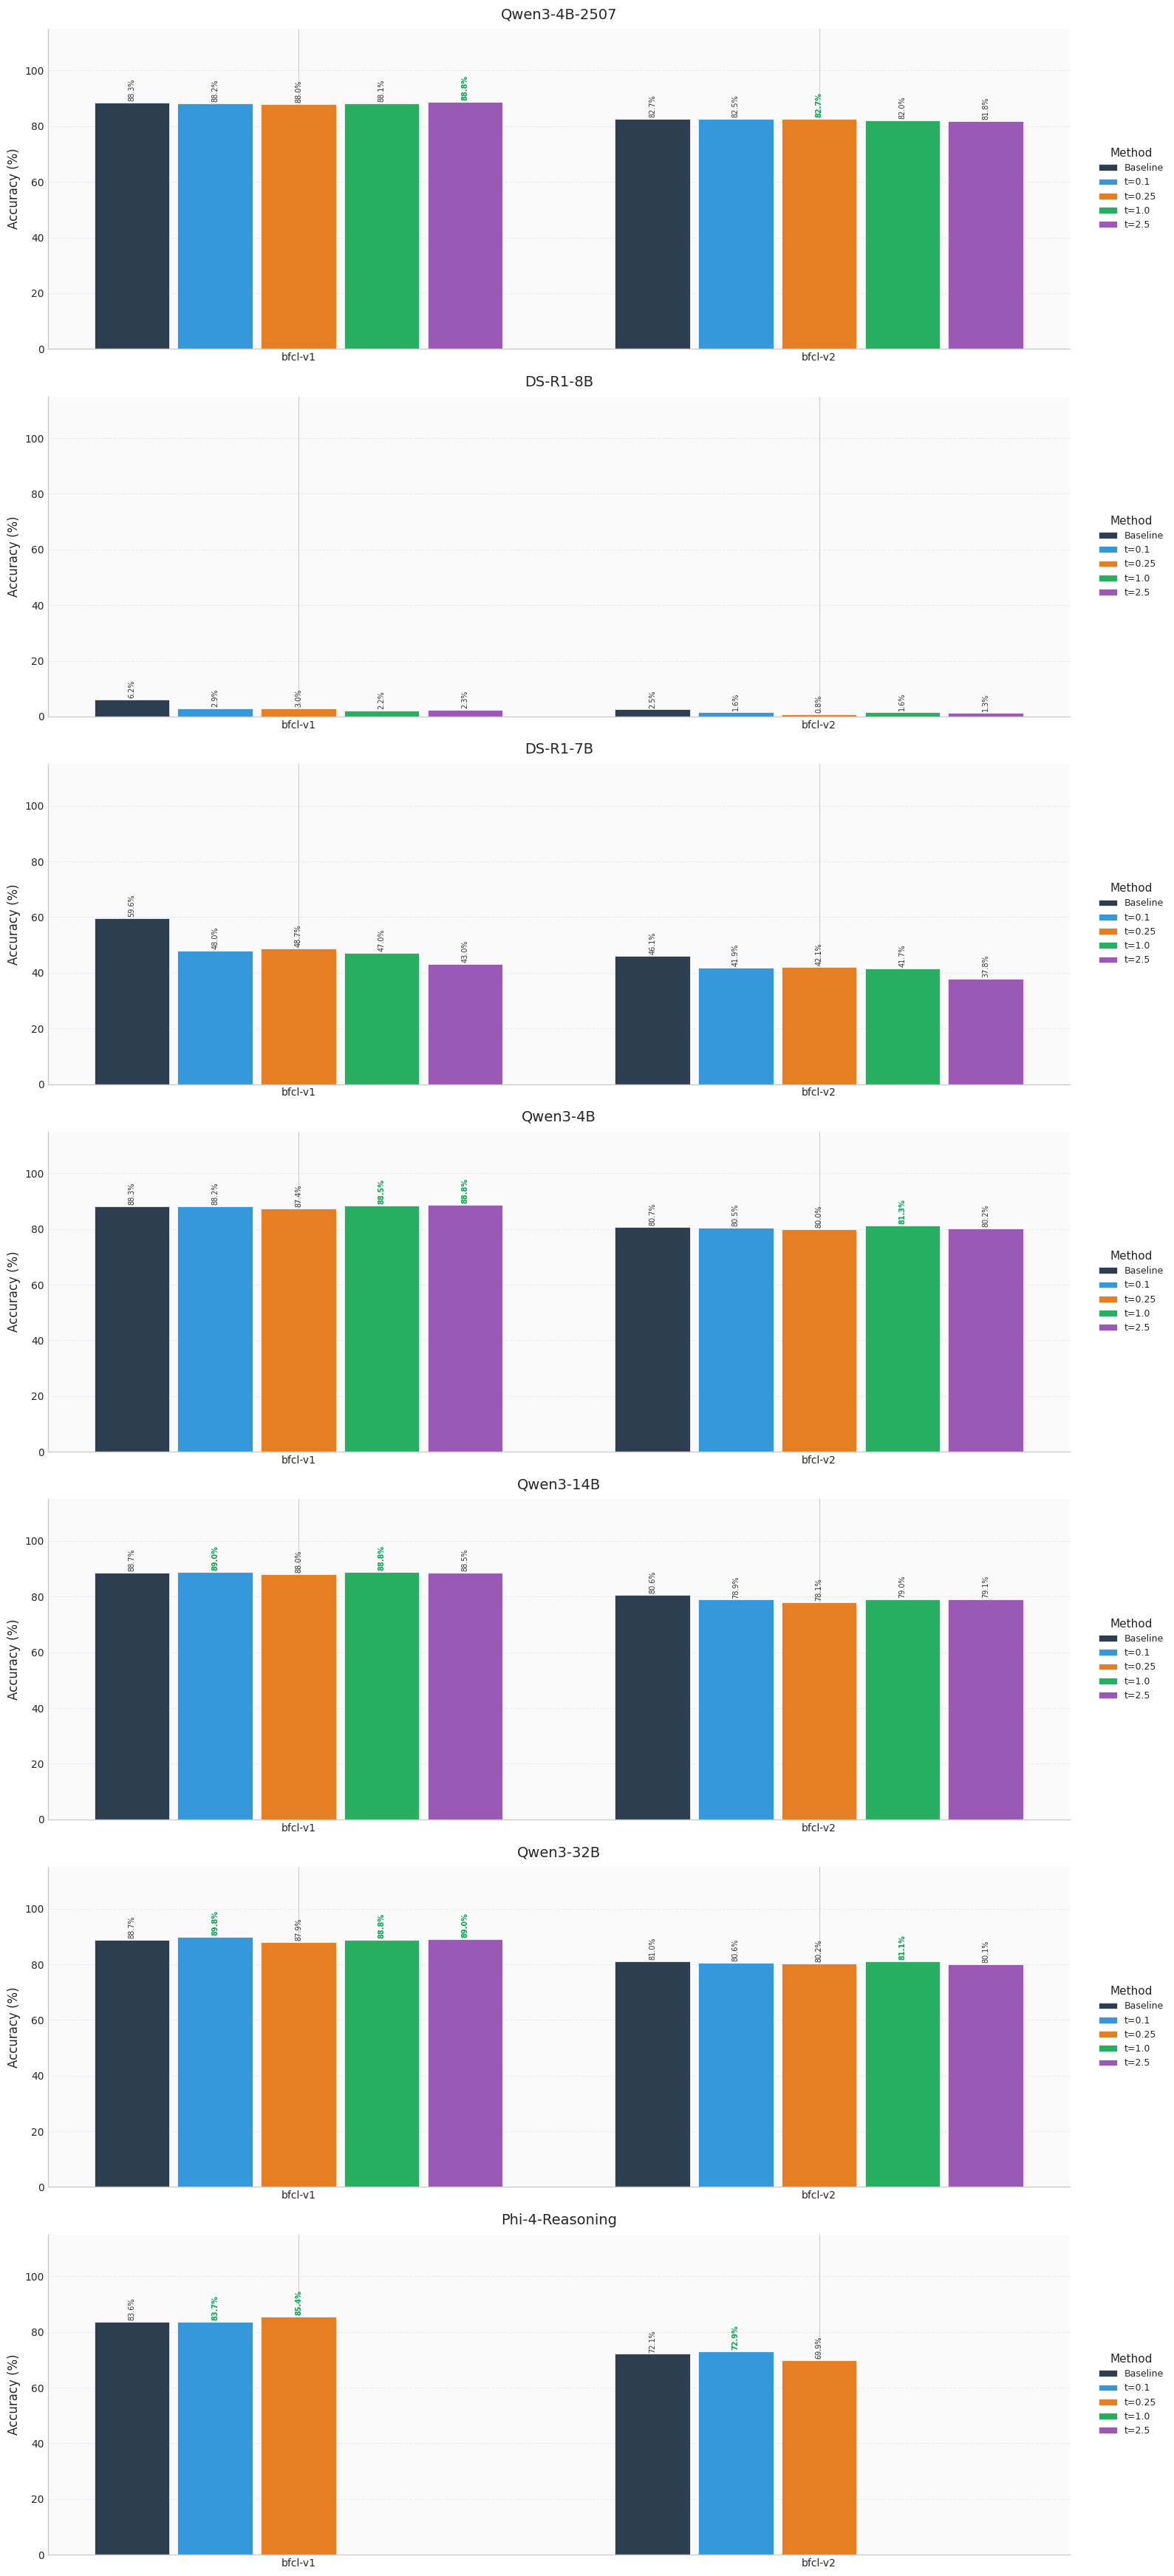

In [6]:
num_models = len(filtered_rollout_data)
if num_models == 0:
    print("No data available for this plot.")
else:
    methods = ["Baseline"] + [f"t={t}" for t in thresholds]

    fig, axes = plt.subplots(num_models, 1, figsize=(16, 5 * num_models))
    if num_models == 1:
        axes = [axes]

    for model_idx, (rollout_name, rollout_model_data) in enumerate(
        filtered_rollout_data.items()
    ):
        ax = axes[model_idx]
        mapped_name = model_name_map.get(rollout_name, rollout_name)
        display_name = short_names.get(mapped_name, rollout_name)

        model_benchmarks = []
        model_accuracies = {m: [] for m in methods}

        for benchmark in benchmarks:
            try:
                if benchmark not in rollout_model_data:
                    continue

                model_benchmarks.append(benchmark)
                model_accuracies["Baseline"].append(
                    rollout_model_data[benchmark]["accuracy"]
                )

                if (
                    mapped_name in filtered_thinkbrake_data
                    and benchmark in filtered_thinkbrake_data[mapped_name]
                ):
                    tb_data = filtered_thinkbrake_data[mapped_name][benchmark]
                    for thresh in thresholds:
                        key = f"threshold_{thresh}"
                        if key in tb_data:
                            model_accuracies[f"t={thresh}"].append(
                                tb_data[key]["accuracy"]
                            )
                        else:
                            model_accuracies[f"t={thresh}"].append(0)
                else:
                    for t in thresholds:
                        model_accuracies[f"t={t}"].append(0)
            except Exception:
                continue

        if model_benchmarks:
            x = np.arange(len(model_benchmarks))
            n_methods = len(methods)
            width = 0.8 / n_methods

            for i, method in enumerate(methods):
                try:
                    if model_accuracies[method]:
                        bars = ax.bar(
                            x + (i - n_methods / 2 + 0.5) * width,
                            model_accuracies[method],
                            width * 0.9,
                            label=method,
                            color=bar_colors[i % len(bar_colors)],
                            edgecolor="white",
                            linewidth=0.5,
                        )
                        # Add percentage labels on bars
                        for bar_idx, (bar, val) in enumerate(
                            zip(bars, model_accuracies[method])
                        ):
                            if val > 0:
                                baseline_val = model_accuracies["Baseline"][bar_idx]
                                if method != "Baseline" and val >= baseline_val:
                                    text_color = "#00A94F"
                                    fontweight = "bold"
                                else:
                                    text_color = "#333333"
                                    fontweight = "normal"
                                ax.text(
                                    bar.get_x() + bar.get_width() / 2,
                                    bar.get_height() + 0.5,
                                    f"{val:.1f}%",
                                    ha="center",
                                    va="bottom",
                                    fontsize=7,
                                    color=text_color,
                                    fontweight=fontweight,
                                    rotation=90,
                                )
                except Exception:
                    continue

            ax.set_ylabel("Accuracy (%)")
            ax.set_title(f"{display_name}", fontsize=14, pad=10)
            ax.set_xticks(x)
            ax.set_xticklabels(model_benchmarks, rotation=0, ha="center")
            ax.legend(
                loc="center left",
                bbox_to_anchor=(1.02, 0.5),
                fontsize=9,
                framealpha=0.9,
                ncol=1,
                title="Method",
            )
            ax.grid(True, alpha=0.3, axis="y", linestyle="--")
            ax.set_ylim(0, 115)
            ax.set_facecolor("#FAFAFA")

    plt.tight_layout()
    plt.show()

## Load Detailed Results Data

In [7]:
def load_all_detailed_results(model_dirs, benchmarks, best_threshold="0.25"):
    all_results = {}

    for model_dir in model_dirs:
        all_results[model_dir] = {}
        for benchmark in benchmarks:
            rollout_results = load_detailed_results(model_dir, benchmark, "rollout")
            thinkbrake_results = load_detailed_results(
                model_dir, benchmark, f"threshold_{best_threshold}"
            )

            if rollout_results and thinkbrake_results:
                all_results[model_dir][benchmark] = {
                    "rollout": rollout_results,
                    "thinkbrake": thinkbrake_results,
                }

    return all_results

In [8]:
BEST_THRESHOLD = 0.1
detailed_results = load_all_detailed_results(
    INCLUDE_MODELS, INCLUDE_BENCHMARKS, BEST_THRESHOLD
)

## Confusion Matrix

In [ ]:
from math_verify import parse, verify
import re


def extract_multiple_choice_answer(response: str) -> str:
    patterns = [
        r'["\*]*answer["\*]*\s*[:=]\s*["\']?([A-Da-d])["\']?',
        r"(?:the\s+)?answer\s+is[:\s]*([A-Da-d])\b",
        r"final\s+answer[:\s]*([A-Da-d])\b",
        r"(?:choice|option)[:\s]*([A-Da-d])\b",
        r"\b([A-Da-d])\s*$",
    ]

    for pattern in patterns:
        matches = re.findall(pattern, response, re.IGNORECASE)
        if matches:
            return matches[-1].upper()

    standalone_matches = re.findall(r"\b([A-Da-d])\b", response)
    if standalone_matches:
        return standalone_matches[-1].upper()

    return ""


def verify_multiple_choice(ground_truth: str, predicted: str) -> bool:
    """Verify if the predicted multiple choice answer matches the ground truth."""
    if not predicted:
        return False
    return ground_truth.upper().strip() == predicted.upper().strip()


def evaluate_item(item: dict, is_multiple_choice: bool) -> bool:
    """
    Evaluate a single item using the same logic as evaluate.py
    """
    if is_multiple_choice:
        ground_truth = item["answer"]
        predicted = extract_multiple_choice_answer(item["response"])
        return verify_multiple_choice(ground_truth, predicted)
    else:
        # Math evaluation using math_verify
        try:
            ground_truth = parse(f"${item['answer']}$")
            predicted = parse(item["response"])
            return verify(ground_truth, predicted)
        except Exception:
            return False


def compute_confusion_matrix(rollout_results, thinkbrake_results, benchmark):
    """Compute confusion matrix comparing rollout (baseline) vs thinkbrake results"""
    rollout_dict = {r["id"]: r for r in rollout_results}
    thinkbrake_dict = {r["id"]: r for r in thinkbrake_results}

    # Determine if it's a multiple choice benchmark
    general_benchmarks = ["gpqa-diamond", "mmlu-redux"]
    is_multiple_choice = benchmark in general_benchmarks

    both_correct = 0
    only_rollout_correct = 0
    only_thinkbrake_correct = 0
    both_wrong = 0

    # Find common IDs
    common_ids = set(rollout_dict.keys()) & set(thinkbrake_dict.keys())

    for pid in common_ids:
        rollout_item = rollout_dict[pid]
        tb_item = thinkbrake_dict[pid]

        # Evaluate using the same method as evaluate.py
        rollout_correct = evaluate_item(rollout_item, is_multiple_choice)
        tb_correct = evaluate_item(tb_item, is_multiple_choice)

        if rollout_correct and tb_correct:
            both_correct += 1
        elif rollout_correct and not tb_correct:
            only_rollout_correct += 1
        elif not rollout_correct and tb_correct:
            only_thinkbrake_correct += 1
        else:
            both_wrong += 1

    return (
        both_correct,
        only_rollout_correct,
        only_thinkbrake_correct,
        both_wrong,
        len(common_ids),
    )

In [ ]:
confusion_data = {}

for model_dir, benchmarks_data in detailed_results.items():
    display_name = short_names.get(model_name_map.get(model_dir, model_dir), model_dir)
    confusion_data[display_name] = {}

    for benchmark, data in benchmarks_data.items():
        if data["rollout"] and data["thinkbrake"]:
            cm = compute_confusion_matrix(
                data["rollout"], data["thinkbrake"], benchmark
            )
            confusion_data[display_name][benchmark] = {
                "both_correct": cm[0],
                "only_rollout": cm[1],
                "only_thinkbrake": cm[2],
                "both_wrong": cm[3],
                "total": cm[4],
            }


n_models = len([m for m in confusion_data if confusion_data[m]])
if n_models > 0:
    fig, axes = create_dynamic_subplots(n_models, max_cols=3)

    for idx, (model_name, bench_data) in enumerate(confusion_data.items()):
        if not bench_data:
            continue
        ax = axes[idx]

        total_both_correct = sum(d["both_correct"] for d in bench_data.values())
        total_only_rollout = sum(d["only_rollout"] for d in bench_data.values())
        total_only_tb = sum(d["only_thinkbrake"] for d in bench_data.values())
        total_both_wrong = sum(d["both_wrong"] for d in bench_data.values())
        total = sum(d["total"] for d in bench_data.values())

        # Calculate accuracies
        baseline_acc = (
            (total_both_correct + total_only_rollout) / total * 100 if total > 0 else 0
        )
        tb_acc = (total_both_correct + total_only_tb) / total * 100 if total > 0 else 0

        # Create confusion matrix
        # Rows: ThinkBrake (Correct/Wrong), Cols: Baseline (Correct/Wrong)
        cm = np.array(
            [
                [
                    total_both_correct,
                    total_only_tb,
                ],  # TB Correct: Both correct, Only TB correct
                [
                    total_only_rollout,
                    total_both_wrong,
                ],  # TB Wrong: Only Baseline correct, Both wrong
            ]
        )

        # Plot heatmap
        im = ax.imshow(cm, cmap="Blues")

        # Add labels - fixed orientation
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(["Baseline ✓", "Baseline ✗"])
        ax.set_yticklabels(["ThinkBrake ✓", "ThinkBrake ✗"])
        ax.set_xlabel("Baseline (Rollout)", fontweight="bold")
        ax.set_ylabel(f"ThinkBrake (t={BEST_THRESHOLD})", fontweight="bold")

        # Add text annotations
        for i in range(2):
            for j in range(2):
                pct = cm[i, j] / total * 100 if total > 0 else 0
                text = ax.text(
                    j,
                    i,
                    f"{cm[i, j]}\n({pct:.1f}%)",
                    ha="center",
                    va="center",
                    fontsize=11,
                    color="white" if cm[i, j] > cm.max() / 2 else "black",
                )

        ax.set_title(
            f"{model_name}\nBaseline: {baseline_acc:.1f}% | TB: {tb_acc:.1f}%",
            fontsize=11,
            fontweight="bold",
        )

    plt.suptitle(
        "Confusion Matrix",
        fontsize=14,
        fontweight="bold",
        y=1.02,
    )
    plt.tight_layout()
    plt.show()

## Confusion Matrix by Benchmark

In [ ]:
for model_dir, benchmarks_data in detailed_results.items():
    display_name = short_names.get(model_name_map.get(model_dir, model_dir), model_dir)

    available_benchmarks = [b for b in INCLUDE_BENCHMARKS if b in benchmarks_data]
    n_benchmarks = len(available_benchmarks)

    if n_benchmarks == 0:
        continue

    fig, axes = create_dynamic_subplots(n_benchmarks, max_cols=3)

    for idx, benchmark in enumerate(available_benchmarks):
        ax = axes[idx]
        data = benchmarks_data[benchmark]

        if not data["rollout"] or not data["thinkbrake"]:
            continue

        cm_result = compute_confusion_matrix(
            data["rollout"], data["thinkbrake"], benchmark
        )
        both_correct, only_rollout, only_tb, both_wrong, total = cm_result

        baseline_acc = (both_correct + only_rollout) / total * 100 if total > 0 else 0
        tb_acc = (both_correct + only_tb) / total * 100 if total > 0 else 0
        diff = tb_acc - baseline_acc

        cm = np.array(
            [
                [both_correct, only_tb],
                [only_rollout, both_wrong],
            ]
        )

        # Plot heatmap
        im = ax.imshow(cm, cmap="Blues")

        # Add labels
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(["Base ✓", "Base ✗"], fontsize=9)
        ax.set_yticklabels(["TB ✓", "TB ✗"], fontsize=9)

        for i in range(2):
            for j in range(2):
                pct = cm[i, j] / total * 100 if total > 0 else 0
                ax.text(
                    j,
                    i,
                    f"{cm[i, j]}\n({pct:.1f}%)",
                    ha="center",
                    va="center",
                    fontsize=9,
                    color="white" if cm[i, j] > cm.max() / 2 else "black",
                )

        diff_color = "green" if diff >= 0 else ("red" if diff < 0 else "black")
        diff_sign = "+" if diff == 0 else ""
        ax.set_title(
            f"{benchmark}\nBase: {baseline_acc:.1f}% → TB: {tb_acc:.1f}% ({diff_sign}{diff:.1f}%)",
            fontsize=10,
            fontweight="bold",
            color=diff_color,
        )

    plt.suptitle(
        f"{display_name} - Confusion Matrix by Benchmark (t={BEST_THRESHOLD})",
        fontsize=13,
        fontweight="bold",
        y=1.02,
    )
    plt.tight_layout()
    plt.show()

## Accuracy vs Token Savings Trade-off

In [ ]:
ALL_THRESHOLDS = ["0.1", "0.25", "1.0", "2.5"]


def is_pareto_optimal(points):
    """
    Find Pareto optimal points.
    Points: list of (accuracy_drop, token_savings) tuples
    We want to minimize accuracy_drop and maximize token_savings
    """
    is_optimal = np.ones(len(points), dtype=bool)
    for i, (drop_i, save_i) in enumerate(points):
        for j, (drop_j, save_j) in enumerate(points):
            if i != j:
                # j dominates i if j has less drop AND more savings
                if drop_j <= drop_i and save_j >= save_i:
                    if drop_j < drop_i or save_j > save_i:
                        is_optimal[i] = False
                        break
    return is_optimal


# Collect trade-off data
tradeoff_data = []

for rollout_name, rollout_model_data in filtered_rollout_data.items():
    mapped_name = model_name_map.get(rollout_name, rollout_name)
    display_name = short_names.get(mapped_name, rollout_name)

    if mapped_name not in filtered_thinkbrake_data:
        continue

    tb_model_data = filtered_thinkbrake_data[mapped_name]

    for benchmark in benchmarks:
        if benchmark not in rollout_model_data or benchmark not in tb_model_data:
            continue

        baseline_acc = rollout_model_data[benchmark]["accuracy"]
        baseline_tokens = rollout_model_data[benchmark]["avg_token_length"]

        # Add baseline point
        tradeoff_data.append(
            {
                "model": display_name,
                "benchmark": benchmark,
                "threshold": "Baseline",
                "accuracy": baseline_acc,
                "accuracy_drop": 0,
                "token_savings": 0,
                "avg_tokens": baseline_tokens,
            }
        )

        for thresh in ALL_THRESHOLDS:
            key = f"threshold_{thresh}"
            if key in tb_model_data[benchmark]:
                tb_acc = tb_model_data[benchmark][key]["accuracy"]
                tb_tokens = tb_model_data[benchmark][key]["avg_token_length"]

                acc_drop = baseline_acc - tb_acc
                token_savings = (1 - tb_tokens / baseline_tokens) * 100

                tradeoff_data.append(
                    {
                        "model": display_name,
                        "benchmark": benchmark,
                        "threshold": f"t={thresh}",
                        "accuracy": tb_acc,
                        "accuracy_drop": acc_drop,
                        "token_savings": token_savings,
                        "avg_tokens": tb_tokens,
                    }
                )

df_tradeoff = pd.DataFrame(tradeoff_data)
models = df_tradeoff["model"].unique()

# Single plot: Pareto Frontier with connected lines
fig, ax = plt.subplots(figsize=(12, 8))

# Background gradient for ideal region
ax.fill_between([0, 60], [-12, -12], [0, 0], alpha=0.08, color="#27AE60", zorder=0)
ax.axhspan(-12, 0, xmin=0, xmax=1, alpha=0.05, color="#27AE60", zorder=0)

# Add subtle grid
ax.grid(True, alpha=0.4, linestyle="-", linewidth=0.5, color="#E0E0E0")
ax.set_axisbelow(True)

for idx, model in enumerate(models):
    model_data = df_tradeoff[df_tradeoff["model"] == model]
    avg_data = (
        model_data.groupby("threshold")
        .agg({"accuracy_drop": "mean", "token_savings": "mean"})
        .reset_index()
    )

    # Sort by token savings for proper line connection
    avg_data = avg_data.sort_values("token_savings")

    points = list(zip(avg_data["accuracy_drop"], avg_data["token_savings"]))
    pareto_mask = is_pareto_optimal(points)

    color = line_colors[idx % len(line_colors)]
    marker = markers[idx % len(markers)]

    # Draw connecting lines (lighter)
    ax.plot(
        avg_data["token_savings"],
        avg_data["accuracy_drop"],
        linewidth=1.5,
        color=color,
        alpha=0.4,
        zorder=2,
    )

    # Plot non-Pareto points (smaller, faded)
    non_pareto = avg_data[~pareto_mask]
    ax.scatter(
        non_pareto["token_savings"],
        non_pareto["accuracy_drop"],
        c=color,
        s=80,
        alpha=0.35,
        marker=marker,
        edgecolors="white",
        linewidth=1,
        zorder=3,
    )

    # Highlight Pareto optimal points (larger, prominent)
    pareto_points = avg_data[pareto_mask]
    ax.scatter(
        pareto_points["token_savings"],
        pareto_points["accuracy_drop"],
        c=color,
        s=200,
        marker=marker,
        edgecolors="#2C3E50",
        linewidth=2.5,
        label=model,
        zorder=5,
    )

# Zero line (no accuracy loss)
ax.axhline(y=0, color="#2C3E50", linestyle="--", alpha=0.6, linewidth=2, zorder=1)

# Ideal region annotation
ax.annotate(
    "✓ Ideal Region\n(High Savings, No Accuracy Loss)",
    xy=(45, -6),
    fontsize=11,
    ha="center",
    va="center",
    color="#1E8449",
    fontweight="bold",
    fontstyle="italic",
    bbox=dict(
        boxstyle="round,pad=0.5",
        facecolor="white",
        edgecolor="#27AE60",
        alpha=0.9,
        linewidth=1.5,
    ),
)

# Direction arrow with better styling
ax.annotate(
    "",
    xy=(52, -9),
    xytext=(15, 4),
    arrowprops=dict(
        arrowstyle="-|>", color="#1E8449", lw=2.5, connectionstyle="arc3,rad=-0.1"
    ),
)
ax.text(
    36,
    -4,
    "Better",
    fontsize=11,
    color="#1E8449",
    fontweight="bold",
    rotation=-18,
    fontstyle="italic",
)

# Axis styling
ax.set_xlabel("Token Savings (%)", fontsize=13, fontweight="bold", labelpad=10)
ax.set_ylabel("Accuracy Change (%)", fontsize=13, fontweight="bold", labelpad=10)
ax.set_title(
    "Accuracy vs Token Savings Trade-off (Pareto Frontier)",
    fontsize=15,
    fontweight="bold",
    pad=15,
)

# Legend with better positioning
legend = ax.legend(
    loc="upper left",
    fontsize=10,
    framealpha=0.95,
    edgecolor="#CCCCCC",
    fancybox=True,
    shadow=True,
    title="Model",
    title_fontsize=11,
)
legend.get_title().set_fontweight("bold")

# Set axis limits with padding
ax.set_xlim(-2, 58)
ax.set_ylim(-12, 8)

# Background color
ax.set_facecolor("#FAFAFA")

# Spine styling
for spine in ax.spines.values():
    spine.set_color("#CCCCCC")
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()

## Token Length Distribution Analysis

In [ ]:
available_models = df_tokens["model"].unique()

for model in available_models:
    model_data = df_tokens[df_tokens["model"] == model]
    benchmarks_in_model = model_data["benchmark"].unique()
    n_benchmarks = len(benchmarks_in_model)

    if n_benchmarks == 0:
        continue

    fig, axes = create_dynamic_subplots(n_benchmarks, max_cols=3)

    for idx, benchmark in enumerate(benchmarks_in_model):
        ax = axes[idx]
        bench_data = model_data[model_data["benchmark"] == benchmark]

        # Box plot by correctness
        baseline_correct = bench_data[
            (bench_data["method"] == "Baseline") & (bench_data["correct"])
        ]["tokens"]
        baseline_wrong = bench_data[
            (bench_data["method"] == "Baseline") & (~bench_data["correct"])
        ]["tokens"]
        tb_correct = bench_data[
            (bench_data["method"] == f"ThinkBrake (t={BEST_THRESHOLD})")
            & (bench_data["correct"])
        ]["tokens"]
        tb_wrong = bench_data[
            (bench_data["method"] == f"ThinkBrake (t={BEST_THRESHOLD})")
            & (~bench_data["correct"])
        ]["tokens"]

        data_to_plot = [baseline_correct, baseline_wrong, tb_correct, tb_wrong]
        positions = [0, 1, 3, 4]
        colors_box = ["#27AE60", "#E74C3C", "#27AE60", "#E74C3C"]

        # showfliers=False to hide outliers
        bp = ax.boxplot(
            data_to_plot,
            positions=positions,
            patch_artist=True,
            widths=0.6,
            showfliers=False,
        )

        for patch, color in zip(bp["boxes"], colors_box):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)

        ax.set_xticks([0.5, 3.5])
        ax.set_xticklabels(["Baseline", "ThinkBrake"])
        ax.set_ylabel("Token Count")

        # Add reduction stats
        baseline_mean = bench_data[bench_data["method"] == "Baseline"]["tokens"].mean()
        tb_mean = bench_data[
            bench_data["method"] == f"ThinkBrake (t={BEST_THRESHOLD})"
        ]["tokens"].mean()
        reduction = (1 - tb_mean / baseline_mean) * 100 if baseline_mean > 0 else 0

        ax.set_title(
            f"{benchmark}\n(Reduction: {reduction:.1f}%)",
            fontsize=10,
            fontweight="bold",
            color="green" if reduction > 0 else "red",
        )
        ax.grid(True, alpha=0.3, axis="y")
        ax.set_facecolor("#FAFAFA")

        # Legend
        legend_elements = [
            Patch(facecolor="#27AE60", alpha=0.6, label="Correct"),
            Patch(facecolor="#E74C3C", alpha=0.6, label="Wrong"),
        ]
        ax.legend(handles=legend_elements, loc="upper right", fontsize=7)

    plt.suptitle(
        f"Token Length by Correctness - {model}", fontsize=14, fontweight="bold", y=1.02
    )
    plt.tight_layout()
    plt.show()

## Per-Sample Analysis: Token Change vs Correctness Change

In [ ]:
sample_analysis = []

for model_dir, benchmarks_data in detailed_results.items():
    display_name = short_names.get(model_name_map.get(model_dir, model_dir), model_dir)

    for benchmark, data in benchmarks_data.items():
        if not data["rollout"] or not data["thinkbrake"]:
            continue

        is_mc = benchmark in ["gpqa-diamond", "mmlu-redux"]

        rollout_dict = {r["id"]: r for r in data["rollout"]}
        tb_dict = {r["id"]: r for r in data["thinkbrake"]}

        common_ids = set(rollout_dict.keys()) & set(tb_dict.keys())

        for pid in common_ids:
            r_item = rollout_dict[pid]
            tb_item = tb_dict[pid]

            r_tokens = r_item["token_length"]
            tb_tokens = tb_item["token_length"]

            r_correct = evaluate_item(r_item, is_mc)
            tb_correct = evaluate_item(tb_item, is_mc)

            token_change = tb_tokens - r_tokens
            token_reduction_pct = (
                ((r_tokens - tb_tokens) / r_tokens * 100) if r_tokens > 0 else 0
            )

            if r_correct and tb_correct:
                outcome = "Both Correct"
            elif r_correct and not tb_correct:
                outcome = "Lost (was correct)"
            elif not r_correct and tb_correct:
                outcome = "Gained (was wrong)"
            else:
                outcome = "Both Wrong"

            sample_analysis.append(
                {
                    "model": display_name,
                    "benchmark": benchmark,
                    "id": pid,
                    "baseline_tokens": r_tokens,
                    "thinkbrake_tokens": tb_tokens,
                    "token_change": token_change,
                    "token_reduction_pct": token_reduction_pct,
                    "baseline_correct": r_correct,
                    "thinkbrake_correct": tb_correct,
                    "outcome": outcome,
                }
            )

df_samples = pd.DataFrame(sample_analysis)

lower_pct, upper_pct = 1, 99
x_lower, x_upper = np.percentile(df_samples["baseline_tokens"], [lower_pct, upper_pct])
y_lower, y_upper = np.percentile(
    df_samples["token_reduction_pct"], [lower_pct, upper_pct]
)

df_filtered = df_samples[
    (df_samples["baseline_tokens"] >= x_lower)
    & (df_samples["baseline_tokens"] <= x_upper)
    & (df_samples["token_reduction_pct"] >= y_lower)
    & (df_samples["token_reduction_pct"] <= y_upper)
].copy()

print(
    f"Original samples: {len(df_samples):,}, After filtering: {len(df_filtered):,} ({len(df_filtered)/len(df_samples)*100:.1f}%)"
)

outcomes = ["Both Correct", "Both Wrong", "Gained (was wrong)", "Lost (was correct)"]
outcome_colors = ["#27AE60", "#95A5A6", "#3498DB", "#E74C3C"]

fig = plt.figure(figsize=(14, 10))

gs = fig.add_gridspec(
    2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0.05, wspace=0.05
)

ax_main = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_main)

hb = ax_main.hexbin(
    df_filtered["baseline_tokens"],
    df_filtered["token_reduction_pct"],
    gridsize=30,
    cmap="Greys",
    alpha=0.3,
    mincnt=1,
)

for i, outcome in enumerate(outcomes):
    subset = df_filtered[df_filtered["outcome"] == outcome]
    n_samples = len(subset)

    # Adjust marker size based on category (larger for rare categories)
    if outcome in ["Gained (was wrong)", "Lost (was correct)"]:
        size = 60
        alpha = 0.8
        zorder = 5
    else:
        size = 25
        alpha = 0.4
        zorder = 3

    ax_main.scatter(
        subset["baseline_tokens"],
        subset["token_reduction_pct"],
        c=outcome_colors[i],
        label=f"{outcome} (n={n_samples})",
        alpha=alpha,
        s=size,
        edgecolors=(
            "white"
            if outcome in ["Gained (was wrong)", "Lost (was correct)"]
            else "none"
        ),
        linewidth=0.5,
        zorder=zorder,
    )

ax_main.axhline(
    y=0, color="#2C3E50", linestyle="--", alpha=0.7, linewidth=2, label="No change"
)
median_val = df_filtered["token_reduction_pct"].median()
ax_main.axhline(
    y=median_val,
    color="#9B59B6",
    linestyle=":",
    alpha=0.6,
    linewidth=1.5,
    label=f"Median ({median_val:.1f}%)",
)

ax_main.set_xlabel("Baseline Token Count", fontsize=12, fontweight="bold")
ax_main.set_ylabel("Token Reduction (%)", fontsize=12, fontweight="bold")
ax_main.legend(loc="lower right", fontsize=9, framealpha=0.95)
ax_main.grid(True, alpha=0.3, linestyle="--")
ax_main.set_facecolor("#FAFAFA")

# Marginal histogram for x-axis (baseline tokens)
for i, outcome in enumerate(outcomes):
    subset = df_filtered[df_filtered["outcome"] == outcome]
    ax_histx.hist(
        subset["baseline_tokens"],
        bins=40,
        alpha=0.5,
        color=outcome_colors[i],
        edgecolor="white",
        linewidth=0.3,
    )
ax_histx.set_ylabel("Count", fontsize=10)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.set_facecolor("#FAFAFA")
ax_histx.grid(True, alpha=0.3, axis="y", linestyle="--")

for i, outcome in enumerate(outcomes):
    subset = df_filtered[df_filtered["outcome"] == outcome]
    ax_histy.hist(
        subset["token_reduction_pct"],
        bins=40,
        alpha=0.5,
        color=outcome_colors[i],
        orientation="horizontal",
        edgecolor="white",
        linewidth=0.3,
    )
ax_histy.set_xlabel("Count", fontsize=10)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.set_facecolor("#FAFAFA")
ax_histy.grid(True, alpha=0.3, axis="x", linestyle="--")

fig.suptitle(
    "Token Reduction vs Baseline Length by Outcome (1-99 percentile)",
    fontsize=14,
    fontweight="bold",
    y=0.98,
)

plt.tight_layout()
plt.show()

## Threshold Selection Method

In [ ]:
def find_knee_point(x, y):
    if len(x) < 3:
        return None, None

    x_norm = (x - x.min()) / (x.max() - x.min() + 1e-10)
    y_norm = (y - y.min()) / (y.max() - y.min() + 1e-10)

    line_vec = np.array([x_norm[-1] - x_norm[0], y_norm[-1] - y_norm[0]])
    line_vec_norm = line_vec / (np.linalg.norm(line_vec) + 1e-10)

    distances = []
    for i in range(len(x)):
        point_vec = np.array([x_norm[i] - x_norm[0], y_norm[i] - y_norm[0]])
        proj_length = np.dot(point_vec, line_vec_norm)
        proj = proj_length * line_vec_norm
        perp_vec = point_vec - proj
        distances.append(np.linalg.norm(perp_vec))

    knee_idx = np.argmax(distances)
    return x[knee_idx], y[knee_idx], knee_idx


knee_analysis_data = []
all_thresholds_numeric = [0.0] + [float(t) for t in ALL_THRESHOLDS]

for rollout_name, rollout_model_data in filtered_rollout_data.items():
    mapped_name = model_name_map.get(rollout_name, rollout_name)
    display_name = short_names.get(mapped_name, rollout_name)

    if mapped_name not in filtered_thinkbrake_data:
        continue

    tb_model_data = filtered_thinkbrake_data[mapped_name]

    model_acc_drops = {t: [] for t in all_thresholds_numeric}
    model_token_savings = {t: [] for t in all_thresholds_numeric}

    for benchmark in benchmarks:
        if benchmark not in rollout_model_data or benchmark not in tb_model_data:
            continue

        baseline_acc = rollout_model_data[benchmark]["accuracy"]
        baseline_tokens = rollout_model_data[benchmark]["avg_token_length"]

        # Baseline point
        model_acc_drops[0.0].append(0)
        model_token_savings[0.0].append(0)

        for thresh in ALL_THRESHOLDS:
            key = f"threshold_{thresh}"
            if key in tb_model_data[benchmark]:
                tb_acc = tb_model_data[benchmark][key]["accuracy"]
                tb_tokens = tb_model_data[benchmark][key]["avg_token_length"]

                model_acc_drops[float(thresh)].append(baseline_acc - tb_acc)
                model_token_savings[float(thresh)].append(
                    (1 - tb_tokens / baseline_tokens) * 100
                )

    for t in all_thresholds_numeric:
        if model_acc_drops[t]:
            knee_analysis_data.append(
                {
                    "model": display_name,
                    "threshold": t,
                    "avg_acc_drop": np.mean(model_acc_drops[t]),
                    "avg_token_savings": np.mean(model_token_savings[t]),
                }
            )

df_knee = pd.DataFrame(knee_analysis_data)

n_models = len(df_knee["model"].unique())
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

knee_results = {}

for idx, model in enumerate(df_knee["model"].unique()):
    ax = axes[idx]
    model_data = df_knee[df_knee["model"] == model].sort_values("threshold")

    x = model_data["avg_token_savings"].values
    y = model_data["avg_acc_drop"].values
    thresholds = model_data["threshold"].values

    ax.plot(
        x,
        y,
        "o-",
        linewidth=2,
        markersize=10,
        color="#3498DB",
        markeredgecolor="white",
        markeredgewidth=2,
        label="Trade-off curve",
    )

    if len(x) >= 3:
        knee_x, knee_y, knee_idx = find_knee_point(x, y)
        knee_thresh = thresholds[knee_idx]
        knee_results[model] = {
            "threshold": knee_thresh,
            "token_savings": knee_x,
            "acc_drop": knee_y,
        }

        ax.scatter(
            [knee_x],
            [knee_y],
            s=300,
            c="#E74C3C",
            marker="*",
            zorder=5,
            edgecolors="white",
            linewidth=2,
            label=f"Knee (t={knee_thresh})",
        )

        ax.plot(
            [x[0], x[-1]], [y[0], y[-1]], "--", color="gray", alpha=0.5, linewidth=1.5
        )

        # Annotate threshold values
        for i, (xi, yi, ti) in enumerate(zip(x, y, thresholds)):
            offset = (5, 5) if i % 2 == 0 else (-15, -15)
            ax.annotate(
                f"t={ti}",
                (xi, yi),
                textcoords="offset points",
                xytext=offset,
                fontsize=8,
                alpha=0.7,
            )

    ax.axhline(y=0, color="green", linestyle="--", alpha=0.5, linewidth=1.5)
    ax.set_xlabel("Token Savings (%)")
    ax.set_ylabel("Accuracy Drop (%)")
    ax.set_title(f"{model}", fontsize=11, fontweight="bold")
    ax.legend(loc="upper left", fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_facecolor("#FAFAFA")

for idx in range(n_models, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle(
    "Optimal Trade-off Threshold per Model",
    fontsize=14,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()